<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#Графический-анализ-результатов" data-toc-modified-id="Графический-анализ-результатов-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Графический анализ результатов</a></span></li></ul></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
display(df.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
print(df.index.is_monotonic)

True


In [6]:
df = df.resample('1H').sum()

## Анализ

In [7]:
plt.rcParams.update({'font.size': 18})

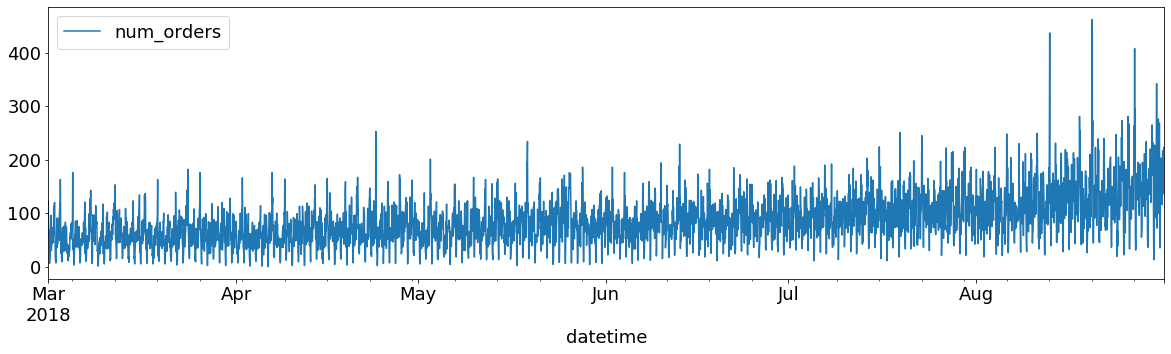

In [8]:
df.plot(figsize=(20, 5))
plt.show()

In [9]:
decomposed = seasonal_decompose(df)
seasonality = decomposed.seasonal
trend = decomposed.trend
residuals = decomposed.resid

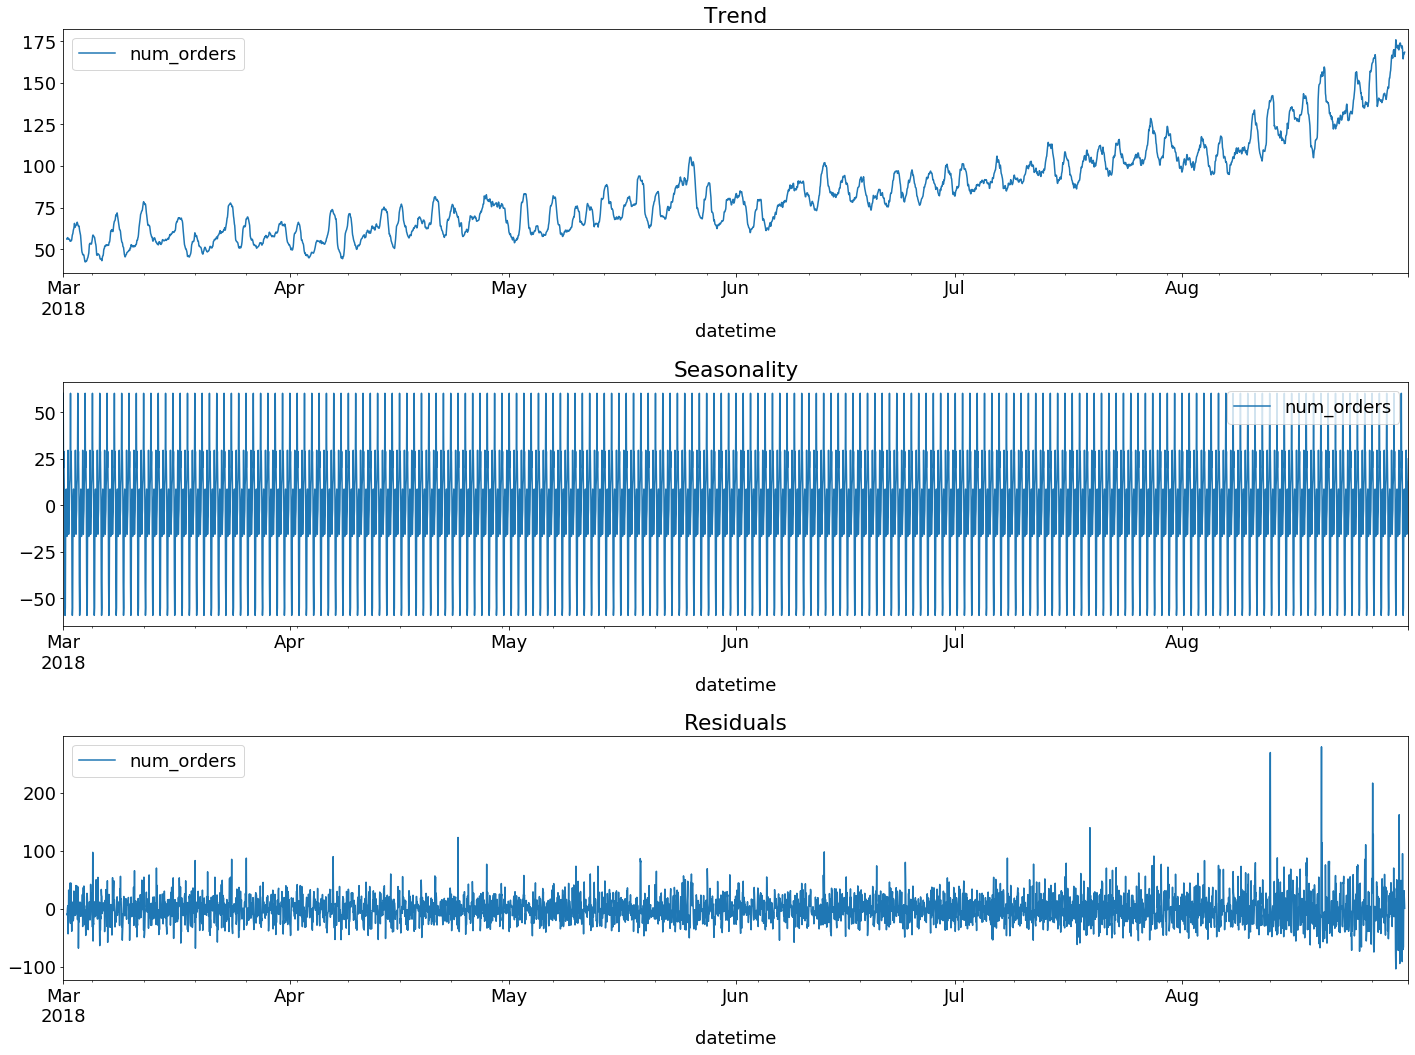

In [10]:
plt.figure(figsize=(20, 15))

plt.subplot(311)
trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
seasonality.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
residuals.plot(ax=plt.gca()) 
plt.title('Residuals')

plt.tight_layout()

График тренда: мы видим рост частоты заказа с 1-го марта до 31-го августа
График сезонности: мы видим сезонность, сливающуюся почти в одну линию, стоит рассмотреть внимательнее

Рассмотрим конкретный день

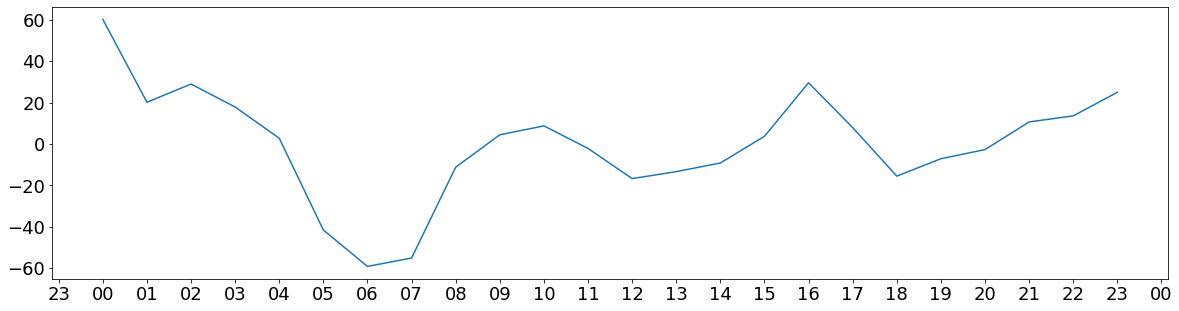

In [11]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(seasonality['2018-03-01'])
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
plt.show()

Хорошо заметно, что на графике есть три пика заказов в течение суток: в 00:00, в 10:00 и в 16:00

## Обучение

Полагаем, что для предсказания временных рядов ключевое значение имеет параметр лага. Теоретически можно было бы сделать автоматический подбор лага, дающий наилучший результат, но мы установим по умолчанию 24 - сутки

In [12]:
def make_features(data, max_lag,  rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features(df, 12, 24)

После этого разделим выборку на обучающую, валидационную и тестовую, так чтобы тестовая составляла 10% данных

In [14]:
general, test = train_test_split(df, shuffle=False, test_size=0.1)

Проверим, все ли поделилось верно

In [15]:
print('Доля общей выборки:', len(general)/len(df))

Доля общей выборки: 0.8999094202898551


Избавимся от пропусков в выборке general

In [16]:
print(general.isna().sum())
general = general.dropna()

num_orders       0
day              0
dayofweek        0
hour             0
lag_1            1
lag_2            2
lag_3            3
lag_4            4
lag_5            5
lag_6            6
lag_7            7
lag_8            8
lag_9            9
lag_10          10
lag_11          11
lag_12          12
rolling_mean    24
dtype: int64


Теперь разделим выборку general на обучающую и валидационную с соотношением 1 к 4.

In [17]:
train, valid = train_test_split(general, shuffle=False, test_size=0.25)
print('Доля обучающей выборки в общей:', len(train)/len(general))

Доля обучающей выборки в общей: 0.7498734177215189


Определим целевые признаки для каждой выборки

In [18]:
features_general = general.drop(columns='num_orders')
target_general = general['num_orders']
features_test = test.drop(columns='num_orders')
target_test = test['num_orders']
features_valid = valid.drop(columns='num_orders')
target_valid = valid['num_orders']
features_train = train.drop(columns='num_orders')
target_train = train['num_orders']

In [30]:
features_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 442 entries, 2018-08-13 14:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 16 columns):
day             442 non-null int64
dayofweek       442 non-null int64
hour            442 non-null int64
lag_1           442 non-null float64
lag_2           442 non-null float64
lag_3           442 non-null float64
lag_4           442 non-null float64
lag_5           442 non-null float64
lag_6           442 non-null float64
lag_7           442 non-null float64
lag_8           442 non-null float64
lag_9           442 non-null float64
lag_10          442 non-null float64
lag_11          442 non-null float64
lag_12          442 non-null float64
rolling_mean    442 non-null float64
dtypes: float64(13), int64(3)
memory usage: 58.7 KB


### Линейная регрессия

In [19]:
%%time
lin_model = LinearRegression()
lin_model.fit(features_train, target_train)

CPU times: user 6.15 ms, sys: 232 µs, total: 6.38 ms
Wall time: 3.73 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
%%time
lin_model_predictions = lin_model.predict(features_valid)
lin_model_rmse_value = mean_squared_error(target_valid, lin_model_predictions) ** 0.5
print('RMSE предсказанных значений на валидационной выборке = ', lin_model_rmse_value)

RMSE предсказанных значений на валидационной выборке =  37.4380475084962
CPU times: user 15.6 ms, sys: 15.6 ms, total: 31.2 ms
Wall time: 77.7 ms


Такой результат соответствует поставленной задаче

### Случайный лес

In [21]:
best_rfc_model = None
best_result = 1000
best_est = 0
best_depth = 0
for est in range(10, 61, 10):
    for depth in range (1, 20):
        rfc_model = RandomForestRegressor(random_state=42, n_estimators=est, max_depth=depth)
        rfc_model.fit(features_train, target_train)
        rfc_model_predictions = rfc_model.predict(features_valid)
        result = mean_squared_error(target_valid, rfc_model_predictions) ** 0.5 
        if result < best_result:
            best_rfc_model = rfc_model
            best_result = result
            best_est = est
            best_depth = depth

print('RMSE предсказанных значений на валидационной выборке = ', best_result)
print("Кол-во деревьев:", best_est)
print("Максимальная глубина:", best_depth)

RMSE предсказанных значений на валидационной выборке =  30.65217214035479
Кол-во деревьев: 20
Максимальная глубина: 14


Такой результат соответствует поставленной задаче

### CatBoost

In [22]:
catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   verbose=False,
                                   random_seed=42,
                                   iterations=400,
                                   learning_rate=1,
                                   max_depth=10)

catboost_model.fit(features_train, target_train)


catboost_model_predictions = catboost_model.predict(features_valid)
catboost_rmse_value = mean_squared_error(target_valid, catboost_model_predictions) ** 0.5
print('RMSE предсказанных значений на валидационной выборке = ', catboost_rmse_value)

RMSE предсказанных значений на валидационной выборке =  31.897575422862257


Такой результат соответствует поставленной задаче

## Тестирование

### Линейная регрессия

In [26]:
%%time
lin_model = LinearRegression()
lin_model.fit(features_general, target_general)

CPU times: user 10.1 ms, sys: 196 µs, total: 10.3 ms
Wall time: 5.74 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
%%time
lin_model_predictions = lin_model.predict(features_test)
lin_model_rmse_value = mean_squared_error(target_test, lin_model_predictions) ** 0.5
print('RMSE предсказанных значений на валидационной выборке = ', lin_model_rmse_value)

RMSE предсказанных значений на валидационной выборке =  50.20095606762962
CPU times: user 3.28 ms, sys: 0 ns, total: 3.28 ms
Wall time: 2.52 ms


Линейная регрессия не справилась с тестовой выборкой

### Случайный лес

In [28]:
rfc_model = RandomForestRegressor(random_state=42, n_estimators=best_est, max_depth=best_depth)
rfc_model.fit(features_general, target_general)
rfc_model_predictions = rfc_model.predict(features_test)
rfc_model_rmse_value = mean_squared_error(target_test, rfc_model_predictions) ** 0.5
print('RMSE предсказанных значений на тестовой выборке = ', rfc_model_rmse_value)

RMSE предсказанных значений на тестовой выборке =  43.494716576929285


Случайный лес показал наилучший результат

### CatBoost

In [24]:
catboost_model.fit(features_general, target_general)
catboost_test_model_predictions = catboost_model.predict(features_test)
catboost_test_rmse_value = mean_squared_error(target_test, catboost_test_model_predictions) ** 0.5
print('RMSE предсказанных значений на тестовой выборке = ', catboost_test_rmse_value)

RMSE предсказанных значений на тестовой выборке =  48.11898543199302


Кэтбуст показал значение RMSE на границе требуемого. Вероятно, менее удовлетворительный результат по сравнению со случайным лесом связан с неправильно подобранными гиперпараметрами.

### Графический анализ результатов

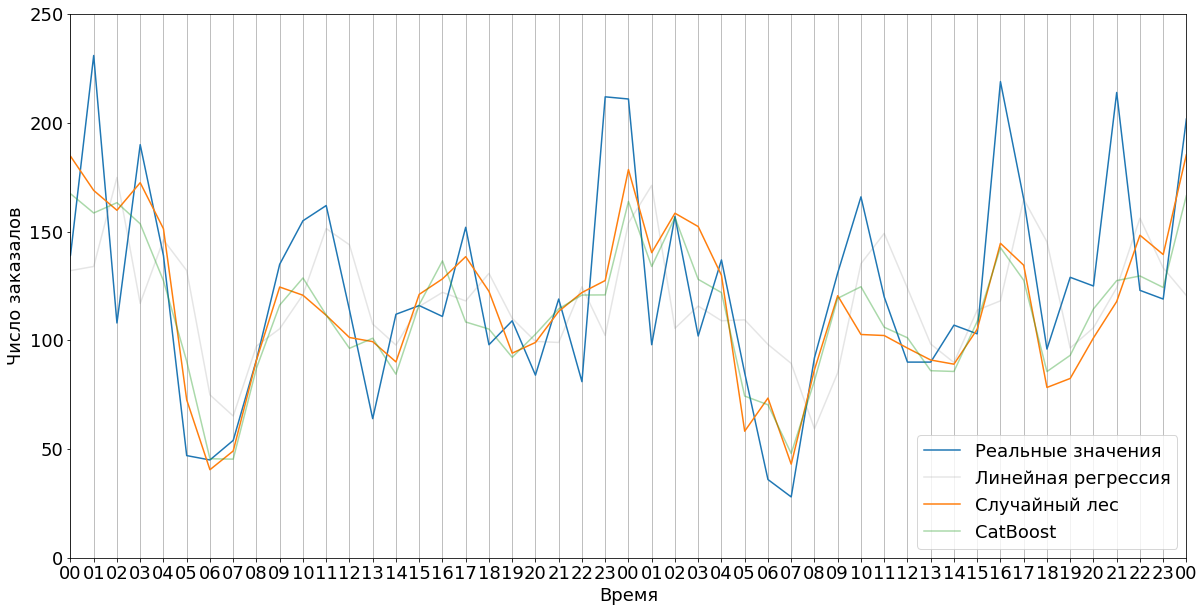

In [57]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(features_test.index, target_test, label='Реальные значения')
ax.plot(features_test.index, lin_model_predictions, label='Линейная регрессия', color='gray', alpha=0.2)
ax.plot(features_test.index, rfc_model_predictions, label='Случайный лес')
ax.plot(features_test.index, catboost_test_model_predictions, label='CatBoost', alpha=0.4)
ax.legend()
ax.set_xlim(left=['2018-08-14'], right=['2018-08-16'])
ax.set_ylim(0,250)
ax.xaxis.set_major_locator(mdates.HourLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.grid(True, axis='x')
plt.xlabel('Время')
plt.ylabel('Число заказалов')
plt.show()

Как видно на графике выше, проблема всех моделей заключается в том, что не не могут предсказать резкие перепады и сглаживают предсказания.